# DTSA 5511 Introduction to Deep Learning - WEEK 5
## GANs on Generative Dog Images 

## Overview

This project aims to implement GANs (Generative Adversarial Networks) to create images of dogs. I will tap on established algorithms for help in generating discriminator and generator models. 

The competition can be found in this link: https://www.kaggle.com/competitions/generative-dog-images/overview. The data contains 20,579 dog images and 20,580 annotations of breeds.

This notebook is created in google colab due to limitations of PC computing power. We will perform EDA, image preprocessing, building the genrator and discriminator models, train the dataset and produce output images.

### Exploratory Data Analysis (EDA) 

In [47]:
#load packages
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import glob
import datetime
from PIL import Image
import cv2
import xml
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import IPython.display as display

import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential, Model
from keras.initializers import TruncatedNormal, RandomNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from keras.optimizers import Adam
from keras import backend as K

#tf.enable_eager_execution()
#print(tf.test.gpu_device_name())

In [1]:
#upload kaggle.json downloaded from kaggle account
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /content/kaggle.json"

!kaggle competitions download -c generative-dog-images

 97% 721M/744M [01:07<00:00, 43.8MB/s]
100% 744M/744M [01:08<00:00, 11.5MB/s]


In [6]:
%%capture
!unzip "./generative-dog-images.zip"

In [7]:
%%capture
!unzip "./all-dogs.zip"

In [8]:
%%capture
!unzip "./Annotation.zip"

In [21]:
file_list = pd.DataFrame(os.listdir('./all-dogs'), columns =["filename"])

In [22]:
len(file_list)

20579

In [27]:
breeds = glob.glob('/content/Annotation/'+'*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')
len(annotations)

20580

Let ushave a look at 15 sample images of dogs from the all-dogs folder

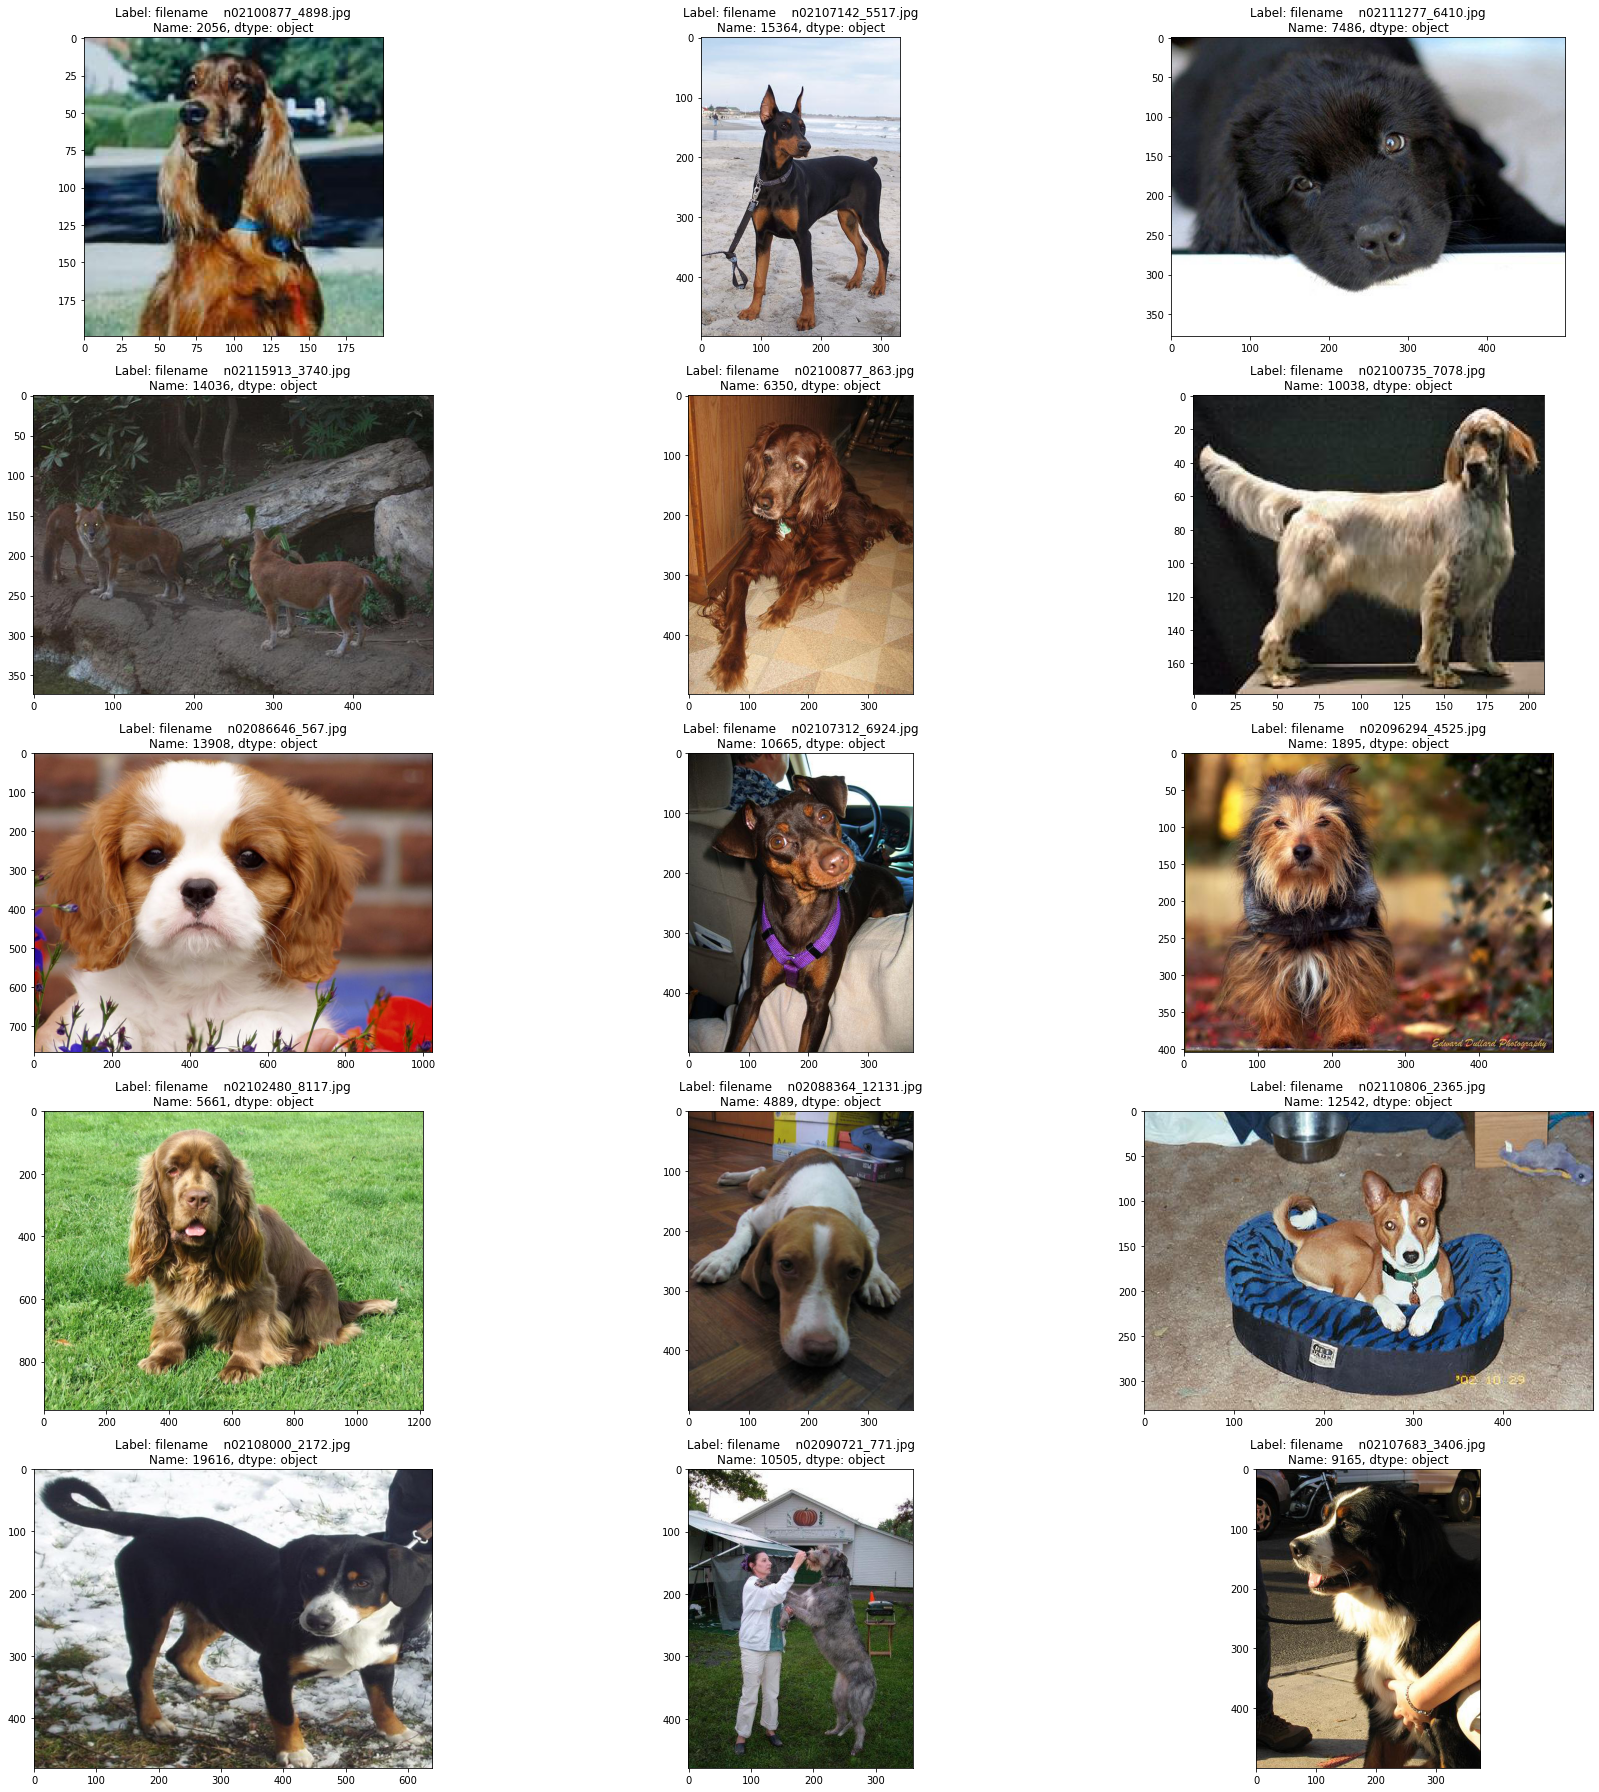

In [19]:
sample = np.random.choice(file_list.index,15)
fig, ax = plt.subplots(5, 3,figsize = (25,25))

for i in range(0, sample.shape[0]):
    ax = plt.subplot(5, 3, i + 1)
    img = mpimg.imread(f'/content/all-dogs/{file_list.iloc[sample[i],0]}')
    ax.imshow(img)
    lab = file_list.iloc[sample[i], ]
    ax.set_title('Label: %s'%lab)
    
plt.tight_layout()

### Image Preprocessing

In [52]:
IMAGES = os.listdir('/content/all-dogs')
BREEDS = os.listdir('/content/Annotation/') 

# variables that determine how tensorflow will create batches after data load
BUFFER_SIZE = 20000
BATCH_SIZE = 32

# weight initializers for the generator network
WEIGHT_INIT = RandomNormal(mean=0.0, stddev=0.05)

# generate/classify 64x64 images
IMG_SIZE = 64

# for training
EPOCHS = 1000
NOISE_SIZE = 128
NB_EXAMPLES_TO_GENERATE = 16

# for animated GIF
seed = tf.random.normal([NB_EXAMPLES_TO_GENERATE, NOISE_SIZE])

In [53]:
# Code modified from https://www.kaggle.com/code/rektmeister/dcgan
imgs = []
names = []

for breed in BREEDS:
    # iterate through each file in the directory
    for dog in os.listdir('/content/Annotation/'+breed):
        try: img = Image.open('/content/all-dogs/'+dog+'.jpg')
        except: continue
        # Element Tree library allows for parsing xml and getting specific tag values
        tree = ET.parse('/content/Annotation/'+breed+'/'+dog)
        # take a look at the print out of an xml previously to get what is going on
        root = tree.getroot() # <annotation>
        objects = root.findall('object') # <object>
        for o in objects:
            bndbox = o.find('bndbox') # <bndbox>
            xmin = int(bndbox.find('xmin').text) # <xmin>
            ymin = int(bndbox.find('ymin').text) # <ymin>
            xmax = int(bndbox.find('xmax').text) # <xmax>
            ymax = int(bndbox.find('ymax').text) # <ymax>
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            imgs.append(np.asarray(img2))
            names.append(breed)

imgs = np.array(imgs)
names[:] = map(str.lower, names)

In [60]:
imgs.shape

(22125, 64, 64, 3)

In [59]:
names[0]

'n02110958-pug'

In [61]:
#normalize imgs
imgs = (imgs - 127.5) / 127.5
imgs = imgs.astype(np.float32)

In [76]:
class AdamWithWeightnorm(Adam):
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations, K.floatx())))

        t = K.cast(self.iterations + 1, K.floatx())
        lr_t = lr * K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):

            # if a weight tensor (len > 1) use weight normalized parameterization
            # this is the only part changed w.r.t. keras.optimizers.Adam
            ps = K.get_variable_shape(p)
            if len(ps)>1:

                # get weight normalization parameters
                V, V_norm, V_scaler, g_param, grad_g, grad_V = get_weightnorm_params_and_grads(p, g)

                # Adam containers for the 'g' parameter
                V_scaler_shape = K.get_variable_shape(V_scaler)
                m_g = K.zeros(V_scaler_shape)
                v_g = K.zeros(V_scaler_shape)

                # update g parameters
                m_g_t = (self.beta_1 * m_g) + (1. - self.beta_1) * grad_g
                v_g_t = (self.beta_2 * v_g) + (1. - self.beta_2) * K.square(grad_g)
                new_g_param = g_param - lr_t * m_g_t / (K.sqrt(v_g_t) + self.epsilon)
                self.updates.append(K.update(m_g, m_g_t))
                self.updates.append(K.update(v_g, v_g_t))

                # update V parameters
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * grad_V
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(grad_V)
                new_V_param = V - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)
                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                # if there are constraints we apply them to V, not W
                if getattr(p, 'constraint', None) is not None:
                    new_V_param = p.constraint(new_V_param)

                # wn param updates --> W updates
                add_weightnorm_param_updates(self.updates, new_V_param, new_g_param, p, V_scaler)

            else: # do optimization normally
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                new_p = p_t
                # apply constraints
                if getattr(p, 'constraint', None) is not None:
                    new_p = p.constraint(new_p)
                self.updates.append(K.update(p, new_p))
        return self.updates

def get_weightnorm_params_and_grads(p, g):
    ps = K.get_variable_shape(p)

    # construct weight scaler: V_scaler = g/||V||
    V_scaler_shape = (ps[-1],)  # assumes we're using tensorflow!
    V_scaler = K.ones(V_scaler_shape)  # init to ones, so effective parameters don't change

    # get V parameters = ||V||/g * W
    norm_axes = [i for i in range(len(ps) - 1)]
    V = p / tf.reshape(V_scaler, [1] * len(norm_axes) + [-1])

    # split V_scaler into ||V|| and g parameters
    V_norm = tf.sqrt(tf.reduce_sum(tf.square(V), norm_axes))
    g_param = V_scaler * V_norm

    # get grad in V,g parameters
    grad_g = tf.reduce_sum(g * V, norm_axes) / V_norm
    grad_V = tf.reshape(V_scaler, [1] * len(norm_axes) + [-1]) * \
             (g - tf.reshape(grad_g / V_norm, [1] * len(norm_axes) + [-1]) * V)

    return V, V_norm, V_scaler, g_param, grad_g, grad_V

def add_weightnorm_param_updates(updates, new_V_param, new_g_param, W, V_scaler):
    ps = K.get_variable_shape(new_V_param)
    norm_axes = [i for i in range(len(ps) - 1)]

    # update W and V_scaler
    new_V_norm = tf.sqrt(tf.reduce_sum(tf.square(new_V_param), norm_axes))
    new_V_scaler = new_g_param / new_V_norm
    new_W = tf.reshape(new_V_scaler, [1] * len(norm_axes) + [-1]) * new_V_param
    updates.append(K.update(W, new_W))
    updates.append(K.update(V_scaler, new_V_scaler))

# data based initialization for a given Keras model
def data_based_init(model, input):
    # input can be dict, numpy array, or list of numpy arrays
    if type(input) is dict:
        feed_dict = input
    elif type(input) is list:
        feed_dict = {tf_inp: np_inp for tf_inp,np_inp in zip(model.inputs,input)}
    else:
        feed_dict = {model.inputs[0]: input}

    # add learning phase if required
    if model.uses_learning_phase and K.learning_phase() not in feed_dict:
        feed_dict.update({K.learning_phase(): 1})

    # get all layer name, output, weight, bias tuples
    layer_output_weight_bias = []
    for l in model.layers:
        trainable_weights = l.trainable_weights
        if len(trainable_weights) == 2:
            W,b = trainable_weights
            assert(l.built)
            layer_output_weight_bias.append((l.name,l.get_output_at(0),W,b)) # if more than one node, only use the first

    # iterate over our list and do data dependent init
    sess = K.get_session()
    for l,o,W,b in layer_output_weight_bias:
        print('Performing data dependent initialization for layer ' + l)
        m,v = tf.nn.moments(o, [i for i in range(len(o.get_shape())-1)])
        s = tf.sqrt(v + 1e-10)
        updates = tf.group(W.assign(W/tf.reshape(s,[1]*(len(W.get_shape())-1)+[-1])), b.assign((b-m)/s))
        sess.run(updates, feed_dict)

### Generator Model

<dtype: 'float32'>
(1, 64, 64, 3)


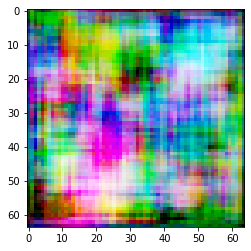

In [65]:
# function will return a generator model
def make_generator():
    model = Sequential([
        Input(shape=(NOISE_SIZE,)),
        Dense(4*4*64, use_bias=False),
        LeakyReLU(),
        Reshape((4, 4, 64)),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT),
        LeakyReLU(),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT),
        LeakyReLU(),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT),
        LeakyReLU(),
        # 64 x 64
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT),
        LeakyReLU(),
        Conv2D(3, (3, 3), padding='same', use_bias=False, activation='tanh', kernel_initializer=WEIGHT_INIT)
    ])
    return model

generator = make_generator()

noise = tf.random.normal([1, NOISE_SIZE])

generated_image = generator(noise, training=False)

print(generated_image.dtype)

plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

### Discriminator Model

In [77]:
def make_discriminator():
    model = tf.keras.Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT),
        LeakyReLU(0.2),
        Dropout(0.25),
        Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT),
        LeakyReLU(0.2),
        Dropout(0.25),
        Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT),
        LeakyReLU(0.2),
        Dropout(0.25),
        Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT),
        LeakyReLU(0.2),
        Dropout(0.25),
        Flatten(),
        Dense(1, activation='sigmoid', kernel_initializer=WEIGHT_INIT)
    ])

    return model


discriminator = make_discriminator()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.62761915]], shape=(1, 1), dtype=float32)


In [78]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

def noisy_labels(y, p_flip=0.05):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0].value)
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0].value)], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

In [79]:
# This method returns a helper function to compute cross entropy loss
# code from tf dcgan tutorial
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# The Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
#     real_output_noisy = noisy_labels(real_output_smooth, 0.05)
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
#     fake_output_noisy = noisy_labels(fake_output_smooth, 0.05)
    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator loss function
def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
#     fake_output_noisy = noisy_labels(fake_output_smooth, 0.05)
    return cross_entropy(fake_output_smooth, fake_output)

# optimizers -- Adam
generator_optimizer = AdamWithWeightnorm(lr=0.0002, beta_1=0.5)
discriminator_optimizer = AdamWithWeightnorm(lr=0.00006, beta_1=0.5)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [80]:
def train_step(images, G_loss_list, D_loss_list):
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    G_loss_list.append(gen_loss.numpy().mean())
    D_loss_list.append(disc_loss.numpy().mean())
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [81]:
def train(dataset, epochs, time_limit=32000):
    training_start = time.time()

    for epoch in range(epochs):
        G_loss = []
        D_loss = []

        start = time.time()
        for image_batch in dataset:
            train_step(image_batch, G_loss, D_loss)
        if (epoch % 10 == 0):
#             display.clear_output(wait=True)
            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed)
        print('epoch {:3d} - G loss: {:.4f} - D loss: {:.4f} - {:.2f} sec'.format(epoch + 1, G_loss[-1], D_loss[-1], time.time()-start))
        if(time.time() - training_start > time_limit):
            print(f"Reached training time limit ({time_limit} s) at {time.time() - training_start:.2f}")
            break

    # Generate after the final epoch
    print("Final Epoch")
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [82]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8,8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1.) / 2.)
        plt.axis('off')
    plt.savefig("img_at_epoch_{}.png".format(epoch+1))
    plt.show()

In [84]:
ds = tf.data.Dataset.from_tensor_slices(imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


## Conclusion and takeaways

Through the help of codes from kaggle users, I was able to replicate the process and undestand the algorithm. The resulting final output images for seems to be improving as the epoch goes on. I needed to stop the runtime due to resources issues but I did generated 12 images. For future analysis, I like to improve more by tuning hyperparameters involved.


Starting training


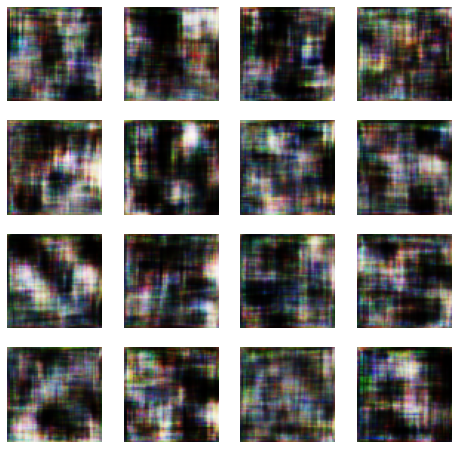

epoch   1 - G loss: 0.5385 - D loss: 1.3956 - 74.50 sec
epoch   2 - G loss: 0.5888 - D loss: 1.3868 - 83.17 sec
epoch   3 - G loss: 0.5353 - D loss: 1.4031 - 67.63 sec
epoch   4 - G loss: 0.6720 - D loss: 1.3937 - 67.41 sec
epoch   5 - G loss: 0.5614 - D loss: 1.3882 - 69.28 sec
epoch   6 - G loss: 0.5523 - D loss: 1.4078 - 82.49 sec
epoch   7 - G loss: 0.4987 - D loss: 1.3968 - 68.30 sec
epoch   8 - G loss: 0.5404 - D loss: 1.3901 - 67.51 sec
epoch   9 - G loss: 0.4609 - D loss: 1.4350 - 67.46 sec
epoch  10 - G loss: 0.5981 - D loss: 1.3575 - 67.28 sec


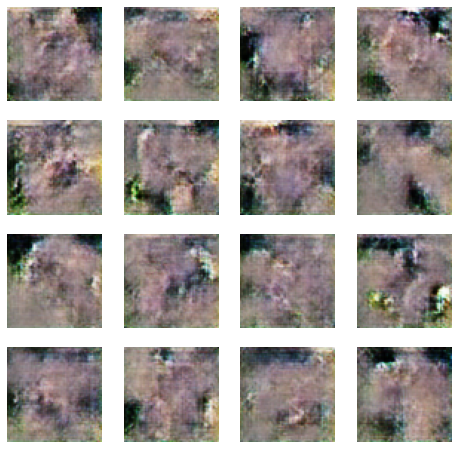

epoch  11 - G loss: 0.5660 - D loss: 1.3767 - 68.18 sec
epoch  12 - G loss: 0.5701 - D loss: 1.3809 - 67.48 sec
epoch  13 - G loss: 0.5748 - D loss: 1.3620 - 67.81 sec
epoch  14 - G loss: 0.5469 - D loss: 1.3937 - 67.25 sec
epoch  15 - G loss: 1.7973 - D loss: 0.6146 - 66.57 sec
epoch  16 - G loss: 0.5651 - D loss: 1.3713 - 66.36 sec
epoch  17 - G loss: 0.6045 - D loss: 1.3709 - 67.13 sec
epoch  18 - G loss: 0.5791 - D loss: 1.3210 - 67.38 sec
epoch  19 - G loss: 0.5425 - D loss: 1.3508 - 67.41 sec
epoch  20 - G loss: 0.6305 - D loss: 1.3664 - 67.26 sec


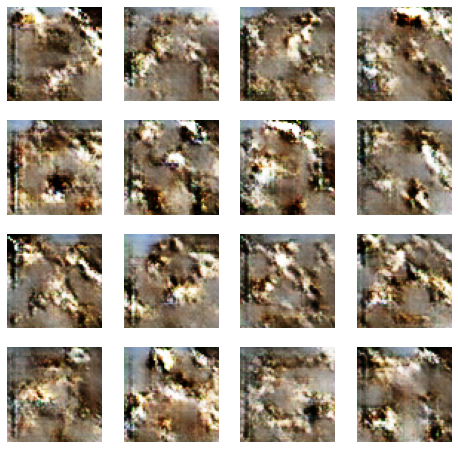

epoch  21 - G loss: 0.5666 - D loss: 1.4026 - 68.31 sec
epoch  22 - G loss: 0.5587 - D loss: 1.3888 - 67.27 sec
epoch  23 - G loss: 0.6086 - D loss: 1.3449 - 66.94 sec
epoch  24 - G loss: 0.5533 - D loss: 1.3654 - 67.18 sec
epoch  25 - G loss: 0.3809 - D loss: 1.5227 - 67.25 sec
epoch  26 - G loss: 2.1845 - D loss: 0.6273 - 66.34 sec
epoch  27 - G loss: 0.5784 - D loss: 1.3896 - 66.30 sec
epoch  28 - G loss: 0.6044 - D loss: 1.3300 - 67.16 sec
epoch  29 - G loss: 0.4898 - D loss: 1.4112 - 67.33 sec
epoch  30 - G loss: 0.6536 - D loss: 1.2488 - 82.48 sec


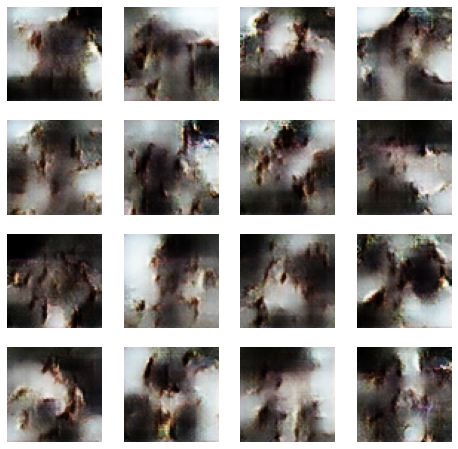

epoch  31 - G loss: 0.6190 - D loss: 1.3934 - 68.05 sec
epoch  32 - G loss: 0.7132 - D loss: 1.2864 - 67.18 sec
epoch  33 - G loss: 0.5957 - D loss: 1.3195 - 70.90 sec
epoch  34 - G loss: 0.6790 - D loss: 1.3473 - 82.49 sec
epoch  35 - G loss: 0.5666 - D loss: 1.3861 - 67.30 sec
epoch  36 - G loss: 0.5536 - D loss: 1.3622 - 67.12 sec
epoch  37 - G loss: 0.5649 - D loss: 1.4078 - 67.36 sec
epoch  38 - G loss: 0.4527 - D loss: 1.4463 - 67.15 sec
epoch  39 - G loss: 0.5410 - D loss: 1.4066 - 67.14 sec
epoch  40 - G loss: 0.6309 - D loss: 1.3673 - 67.31 sec


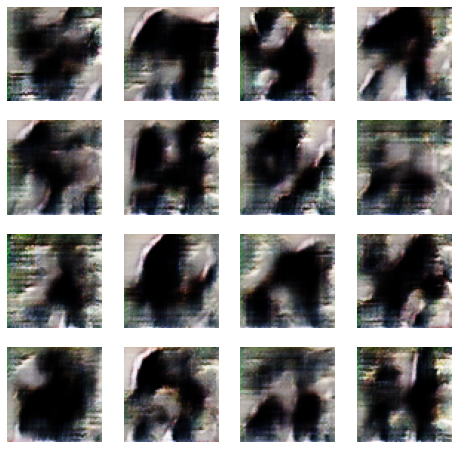

epoch  41 - G loss: 0.5475 - D loss: 1.3375 - 67.96 sec
epoch  42 - G loss: 0.6056 - D loss: 1.3501 - 67.16 sec
epoch  43 - G loss: 0.5010 - D loss: 1.3677 - 67.36 sec
epoch  44 - G loss: 0.6345 - D loss: 1.3463 - 67.15 sec
epoch  45 - G loss: 0.5469 - D loss: 1.1868 - 66.97 sec
epoch  46 - G loss: 0.6366 - D loss: 1.2988 - 67.19 sec
epoch  47 - G loss: 0.6247 - D loss: 1.3200 - 82.48 sec
epoch  48 - G loss: 0.4177 - D loss: 1.4602 - 67.40 sec
epoch  49 - G loss: 0.5765 - D loss: 1.4057 - 66.98 sec
epoch  50 - G loss: 0.6181 - D loss: 1.3943 - 67.07 sec


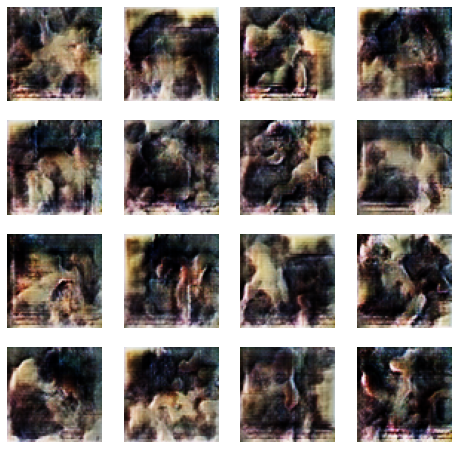

epoch  51 - G loss: 0.6209 - D loss: 1.3678 - 67.73 sec
epoch  52 - G loss: 0.5606 - D loss: 1.4111 - 67.36 sec
epoch  53 - G loss: 0.6037 - D loss: 1.3038 - 66.84 sec
epoch  54 - G loss: 0.5967 - D loss: 1.3383 - 67.08 sec
epoch  55 - G loss: 0.6119 - D loss: 1.3979 - 67.27 sec
epoch  56 - G loss: 0.6354 - D loss: 1.3119 - 67.26 sec
epoch  57 - G loss: 0.7307 - D loss: 1.2795 - 67.42 sec
epoch  58 - G loss: 0.5417 - D loss: 1.3615 - 67.35 sec
epoch  59 - G loss: 0.5857 - D loss: 1.3674 - 67.35 sec
epoch  60 - G loss: 0.6033 - D loss: 1.3807 - 67.22 sec


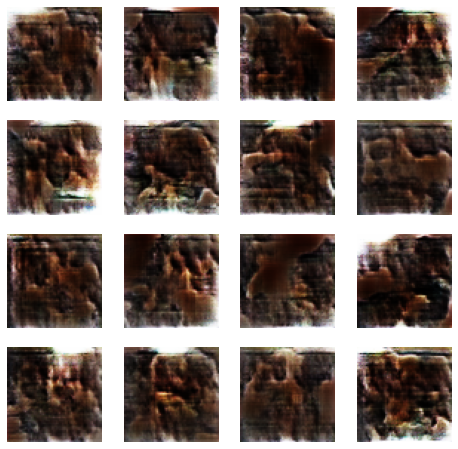

epoch  61 - G loss: 0.6082 - D loss: 1.4335 - 67.85 sec
epoch  62 - G loss: 0.6155 - D loss: 1.3532 - 67.26 sec
epoch  63 - G loss: 0.5620 - D loss: 1.3936 - 67.39 sec
epoch  64 - G loss: 0.5677 - D loss: 1.3736 - 67.24 sec
epoch  65 - G loss: 0.6207 - D loss: 1.3933 - 67.32 sec
epoch  66 - G loss: 0.5318 - D loss: 1.3491 - 67.31 sec
epoch  67 - G loss: 0.6308 - D loss: 1.2804 - 67.02 sec
epoch  68 - G loss: 0.5254 - D loss: 1.3977 - 67.13 sec
epoch  69 - G loss: 0.5478 - D loss: 1.3703 - 67.09 sec
epoch  70 - G loss: 0.5825 - D loss: 1.3901 - 67.23 sec


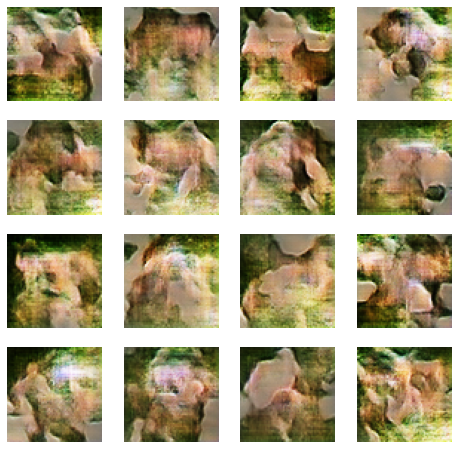

epoch  71 - G loss: 0.5320 - D loss: 1.3263 - 69.26 sec
epoch  72 - G loss: 0.6733 - D loss: 1.3728 - 67.80 sec
epoch  73 - G loss: 0.5940 - D loss: 1.3574 - 67.58 sec
epoch  74 - G loss: 0.5791 - D loss: 1.2769 - 68.05 sec
epoch  75 - G loss: 0.5097 - D loss: 1.3847 - 68.21 sec
epoch  76 - G loss: 0.6882 - D loss: 1.2452 - 67.88 sec
epoch  77 - G loss: 0.8906 - D loss: 1.3199 - 67.67 sec
epoch  78 - G loss: 0.6024 - D loss: 1.2665 - 67.81 sec
epoch  79 - G loss: 0.9185 - D loss: 1.2955 - 67.72 sec
epoch  80 - G loss: 0.5307 - D loss: 1.3580 - 67.29 sec


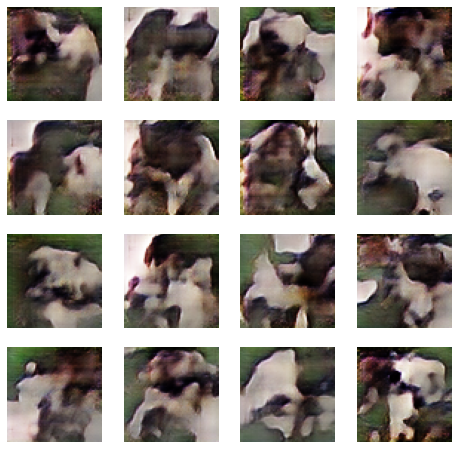

epoch  81 - G loss: 0.6608 - D loss: 1.3751 - 67.84 sec
epoch  82 - G loss: 0.5439 - D loss: 1.2379 - 67.73 sec
epoch  83 - G loss: 0.5524 - D loss: 1.4481 - 67.53 sec
epoch  84 - G loss: 0.4925 - D loss: 1.3418 - 67.50 sec
epoch  85 - G loss: 0.7323 - D loss: 1.1857 - 67.37 sec
epoch  86 - G loss: 0.6007 - D loss: 1.3100 - 67.77 sec
epoch  87 - G loss: 0.5898 - D loss: 1.3525 - 67.53 sec
epoch  88 - G loss: 0.5204 - D loss: 1.3501 - 67.38 sec
epoch  89 - G loss: 0.5300 - D loss: 1.4278 - 67.54 sec
epoch  90 - G loss: 0.6498 - D loss: 1.3247 - 67.09 sec


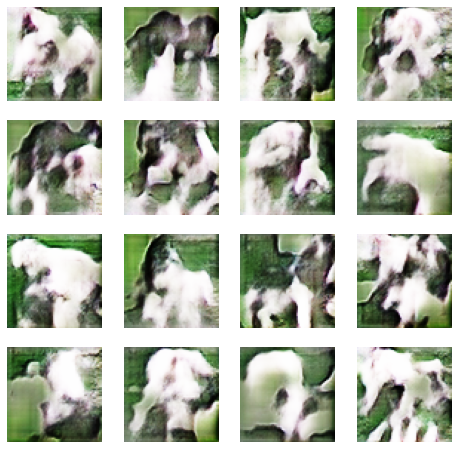

epoch  91 - G loss: 0.6085 - D loss: 1.2759 - 67.99 sec
epoch  92 - G loss: 0.7009 - D loss: 1.3313 - 67.13 sec
epoch  93 - G loss: 0.5661 - D loss: 1.4696 - 67.06 sec
epoch  94 - G loss: 0.6364 - D loss: 1.2512 - 66.73 sec
epoch  95 - G loss: 0.7149 - D loss: 1.2665 - 66.61 sec
epoch  96 - G loss: 0.5112 - D loss: 1.3664 - 66.92 sec
epoch  97 - G loss: 0.6086 - D loss: 1.3784 - 66.86 sec
epoch  98 - G loss: 0.5827 - D loss: 1.2452 - 66.69 sec
epoch  99 - G loss: 0.6870 - D loss: 1.2232 - 66.97 sec
epoch 100 - G loss: 0.7227 - D loss: 1.1955 - 66.66 sec


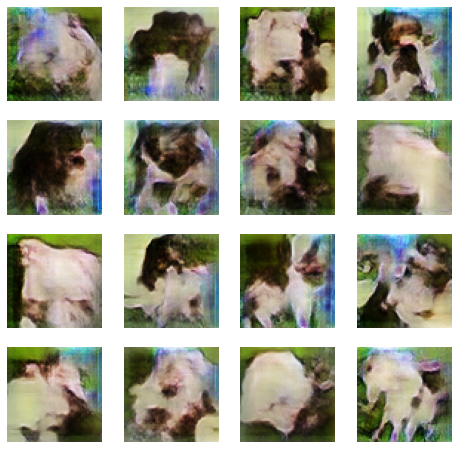

epoch 101 - G loss: 0.5785 - D loss: 1.4049 - 67.40 sec
epoch 102 - G loss: 0.9716 - D loss: 1.2722 - 66.75 sec
epoch 103 - G loss: 0.6531 - D loss: 1.3174 - 66.68 sec
epoch 104 - G loss: 0.5387 - D loss: 1.3634 - 66.67 sec
epoch 105 - G loss: 0.4080 - D loss: 1.5365 - 67.21 sec
epoch 106 - G loss: 0.5937 - D loss: 1.2500 - 67.47 sec
epoch 107 - G loss: 0.5653 - D loss: 1.4564 - 67.16 sec
epoch 108 - G loss: 0.6561 - D loss: 1.3372 - 67.07 sec
epoch 109 - G loss: 0.6166 - D loss: 1.4334 - 67.68 sec
epoch 110 - G loss: 0.6025 - D loss: 1.3922 - 67.25 sec


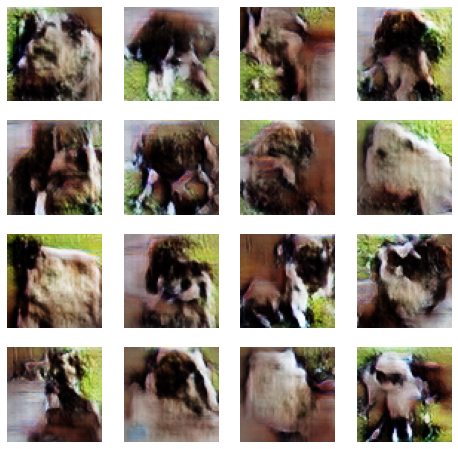

epoch 111 - G loss: 0.4601 - D loss: 1.3003 - 67.82 sec


KeyboardInterrupt: ignored

In [85]:
print('Starting training')
train(ds, EPOCHS)

Code Sources:

https://www.kaggle.com/code/tikutiku/gan-dogs-starter-biggan/notebook

https://www.kaggle.com/code/rektmeister/dcgan